In [15]:
import sys
sys.path.insert(0, "../segmentation_models")
sys.path.insert(0,"../classification_models")

import collections
import cv2 
import gc
import glob
import json
import keras
import numpy as np
import os
import classification_models
import segmentation_models
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import io
from sklearn.preprocessing import normalize
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense
from keras.optimizers import Adam
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
from tqdm import tqdm_notebook as tqdm


In [2]:
input_size = (512,512)

def load_image(path):
    """Load grayscale image from path"""
    return cv2.resize(cv2.imread(path,1), input_size)

def load_binary_image(path):
    """Load grayscale image from path"""
    return cv2.resize(cv2.imread(path,0), input_size)

def load_mat(path):
    """Load grayscale image from path"""
    image = io.loadmat(path, appendmat=False)['dxImage']['img'][0][0]
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    colored_image = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2RGB)
    return cv2.resize(colored_image, input_size)

def load_mask_mat(path):
    """Load grayscale image from path"""
    # import matlab files, extracting array of masks
    mask_list = np.stack(io.loadmat(path, appendmat=False)['maskImage']['maskCrop'][0][0][0], axis=0)
    line_num = len(mask_list)
    
    # create placeholder arrays
    foreground = np.zeros((input_size[0], input_size[1], 1))
    background = np.ones((input_size[0], input_size[1], 1))
    
    # for each mask, scale it, reshape it, and add it to the foreground
    for i, mask in enumerate(mask_list):
        mask_array = cv2.resize(mask.astype(np.uint8), input_size)
        scaled_mask_array = np.reshape(mask_array, (input_size[0], input_size[1], 1))
        foreground = np.logical_or(foreground, scaled_mask_array)
    foreground = np.reshape(foreground, (1, input_size[0], input_size[1], 1))
    
    # create the background mask
    background = 1 - foreground
    
    # combine the background and foreground masks into a single array
    final_mask_list = np.array(np.append(background, foreground, axis=3))
    return final_mask_list

X = []
Y = []
data_dir = "/data/midi-lab-general/osemis_annotations/osemis_annotation_file_to_masks/Masks/*.mat"
for filepath in tqdm(sorted(glob.glob(data_dir, recursive=True))):
    if filepath.endswith("image.mat"):
        X.append(load_mat(filepath))
    if filepath.endswith("mask.mat"):
        Y.append(load_mask_mat(filepath))
X = np.reshape(np.array(X), (-1, input_size[0], input_size[1], 3))
Y = np.reshape(np.array(Y), (len(X), input_size[0], input_size[1], 2))

line_ratio = 0
for image in Y[:,:,:,0]:
    image = np.round(image, decimals=0)
    unique, counts = np.unique(image, return_counts=True)
    d = dict(zip(unique, counts))
    line_ratio += d[1.0]/(d[1.0] + d[0.0])
print(line_ratio/len(Y))


0.9852751096089681


96 Samples; 15 train; 15 val; 15 test


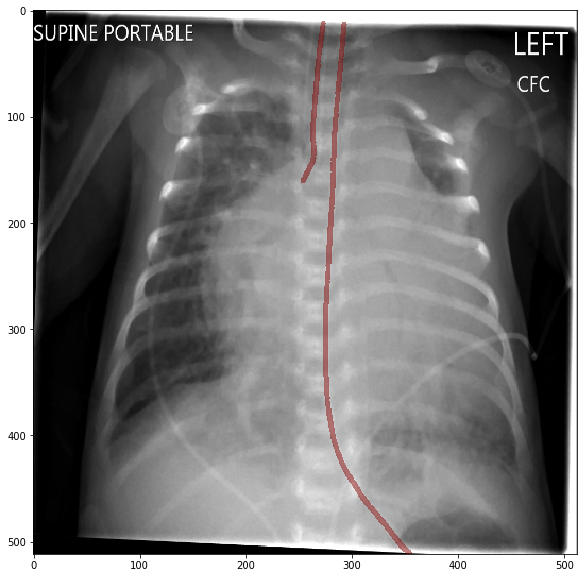

In [3]:
val_split = 0.15
test_split = 0.15
n = len(X)
sp1 = int(((1 - val_split - test_split) * n) - 0.5) # Choose first index with rounding adjustment (0.5)
sp2 = int(((1 - test_split) * n) - 0.5) # Choose second index with rounding adjustment (0.5)
X_train, Y_train = X[:sp1], Y[:sp1]
X_val, Y_val = X[sp1:sp2], Y[sp1:sp2]
X_test, Y_test = X[sp2:], Y[sp2:]
X_train = X_train[:15]
Y_train = Y_train[:15]
print("{} Samples; {} train; {} val; {} test".format(n, len(X_train), len(X_val), len(X_test)))
def plot_sample(sample, figsize=(10,10)):
    print(sample.shape)
    sample = np.squeeze(sample)
    plt.figure(figsize=figsize)
    plt.imshow(sample, cmap='gray')
    plt.show()
def plot_mask(sample, mask, figsize=(10,10)):
    mask = np.squeeze(mask)
    plt.figure(figsize=figsize)
    plt.imshow(sample, cmap='gray')
    plt.imshow(np.ma.masked_where(mask[:, :, 1] <= 0.5, mask[:, :, 1]), cmap='jet', alpha=0.5, vmin=0, vmax=1)
    plt.show()
plot_mask(X[2], Y[2])

In [4]:
epsilon = 0.0001

def dice_coef(y_true, y_pred):
    y_true = y_true[:, :, :, 1]
    y_pred = y_pred[:, :, :, 1]
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def weighted_cce(y_true, y_pred):
    p = K.sum(K.flatten(y_true[...,:1])) / (224**2)
    maximum_w = 1 / K.log(1.02 + 0)
    minimum_w = 1 / K.log(1.02 + 1)
    w = 1 / K.log(1.02 + p)
    scaled_w = (w - minimum_w) / (maximum_w - minimum_w)
    
    y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
    loss_map = -K.sum(scaled_w * y_true * K.log(y_pred), axis=-1)
    return K.mean(K.flatten(loss_map))

def weighted_cce_plus_dice_coef_loss(y_true, y_pred):
    return 0.5*weighted_cce(y_true, y_pred) + 0.5*dice_coef_loss(y_true, y_pred)

def unbalanced_weighted_cce_plus_dice_coef_loss(y_true, y_pred):
    return 0.1*weighted_cce(y_true, y_pred) + 0.9*dice_coef_loss(y_true, y_pred)

In [5]:
# Create UNet model with custom resnet weights
model = Unet('resnet50_custom', 
             classes=2, 
             input_shape=(512, 512, 3), 
             encoder_weights='imagenet', 
             activation='softmax')


Instructions for updating:
Colocations handled automatically by placer.


../classification_models/classification_models/resnet/models.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  new_model = Model(inputs=model.input, output=resnet_base.layers[-2].output)


In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
model.compile(optimizer=Adam(lr=0.0001), loss=dice_coef_loss, metrics=["accuracy", dice_coef])

In [8]:
# Choose checkpoint path
checkpoint_path = "./UNET-with-New-ResNet50_weights"
os.makedirs(checkpoint_path, exist_ok=True)

# Create early stopping callback
early_stopping = EarlyStopping(monitor="val_dice_coef", mode="max", patience=75, verbose=1)

# Create checkpointer to save best model weights
checkpointer = ModelCheckpoint(filepath=checkpoint_path + "/resnet50-custom_small_dice_weights.h5", verbose=1, monitor="val_dice_coef", mode="max", save_best_only=True)

# TEST: ReduceLROnPlateau
callback_list = [checkpointer, early_stopping]

In [9]:
res_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=8, epochs=50, verbose=1, callbacks=callback_list)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 15 samples, validate on 15 samples
Epoch 1/50
15/15 [==============================] - 15s 986ms/step - loss: 0.9602 - acc: 0.9001 - dice_coef: 0.0398 - val_loss: 0.9634 - val_acc: 0.8598 - val_dice_coef: 0.0366

Epoch 00001: val_dice_coef improved from -inf to 0.03659, saving model to ./UNET-with-New-ResNet50_weights/resnet50-custom_small_dice_weights.h5
Epoch 2/50
15/15 [==============================] - 1s 62ms/step - loss: 0.9483 - acc: 0.8885 - dice_coef: 0.0517 - val_loss: 0.9560 - val_acc: 0.8332 - val_dice_coef: 0.0440

Epoch 00002: val_dice_coef improved from 0.03659 to 0.04398, saving model to ./UNET-with-New-ResNet50_weights/resnet50-custom_small_dice_weights.h5
Epoch 3/50
15/15 [==============================] - 1s 59ms/step - loss: 0.9360 - acc: 0.8784 - dice_coef: 0.0640 - val_loss: 0.9509 - val_acc: 0.8497 - val_dice_coef: 0.0491

Epoch 0


Epoch 00029: val_dice_coef did not improve from 0.06781
Epoch 30/50
15/15 [==============================] - 1s 60ms/step - loss: 0.7226 - acc: 0.9766 - dice_coef: 0.2774 - val_loss: 0.9239 - val_acc: 0.9805 - val_dice_coef: 0.0761

Epoch 00030: val_dice_coef improved from 0.06781 to 0.07614, saving model to ./UNET-with-New-ResNet50_weights/resnet50-custom_small_dice_weights.h5
Epoch 31/50
15/15 [==============================] - 1s 60ms/step - loss: 0.7135 - acc: 0.9774 - dice_coef: 0.2865 - val_loss: 0.9253 - val_acc: 0.9813 - val_dice_coef: 0.0747

Epoch 00031: val_dice_coef did not improve from 0.07614
Epoch 32/50
15/15 [==============================] - 1s 60ms/step - loss: 0.7074 - acc: 0.9796 - dice_coef: 0.2926 - val_loss: 0.9311 - val_acc: 0.9829 - val_dice_coef: 0.0689

Epoch 00032: val_dice_coef did not improve from 0.07614
Epoch 33/50
15/15 [==============================] - 1s 60ms/step - loss: 0.6990 - acc: 0.9799 - dice_coef: 0.3010 - val_loss: 0.9264 - val_acc: 0.9825 

In [10]:
# Save history
history_path = checkpoint_path + "/History/" + "resnet50-custom_small_dice_history.json"
print("Writing history dictionary to {}".format(history_path))
with open(history_path, 'w') as history_file:
    json.dump(res_history.history, history_file)

Writing history dictionary to ./UNET-with-New-ResNet50_weights/History/resnet50-custom_small_dice_history.json


In [11]:
model.load_weights(checkpoint_path + "/resnet50-custom_small_dice_weights.h5")
loss, accuracy, dice = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Dice coef:', dice)

Test loss: 0.9322589635848999
Test accuracy: 0.98663330078125
Dice coef: 0.0677410364151001


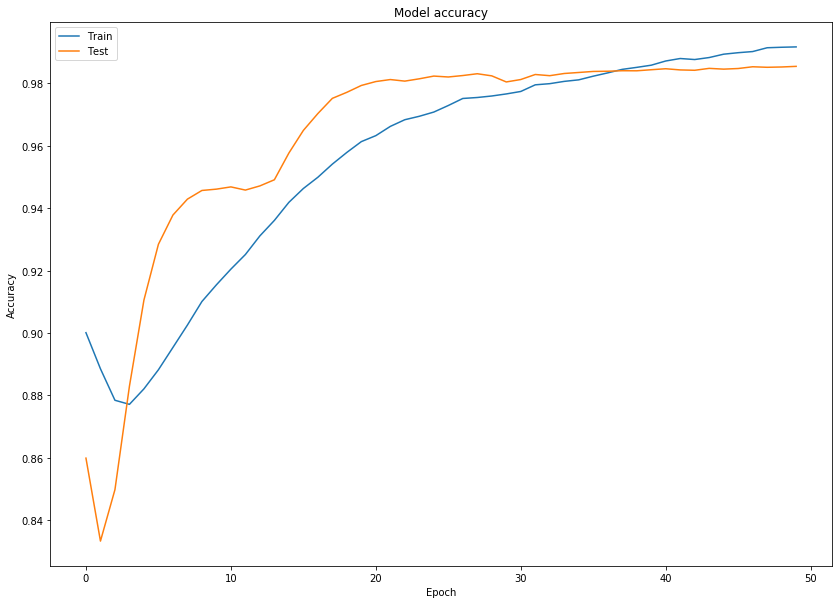

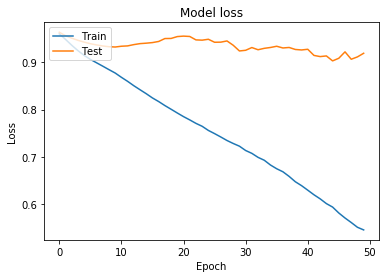

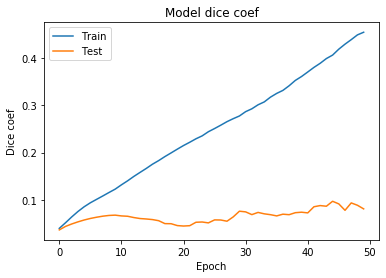

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,10))

plt.plot(res_history.history['acc'])
plt.plot(res_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(res_history.history['loss'])
plt.plot(res_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation dice values
plt.plot(res_history.history['dice_coef'])
plt.plot(res_history.history['val_dice_coef'])
plt.title('Model dice coef')
plt.ylabel('Dice coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
test_id = 1
predicted_mask = model.predict(np.expand_dims(X_test[test_id], axis=0))
plot_mask(X_test[test_id], predicted_mask, figsize=(10,10))
plot_mask(X_test[test_id], Y_test[test_id], figsize=(10,10))

InvalidArgumentError: Tensor input_1:0, specified in either feed_devices or fetch_devices was not found in the Graph

In [17]:
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.Session(config=config))
reset_keras()

12907


In [18]:
# Create UNet model with imagenet weights
model = Unet('resnet50', 
             classes=2, 
             input_shape=(512, 512, 3), 
             encoder_weights='imagenet', 
             activation='softmax')

In [19]:
# Choose checkpoint path
checkpoint_path = "./UNET-with-New-ResNet50_weights"
os.makedirs(checkpoint_path, exist_ok=True)

# Create early stopping callback
early_stopping = EarlyStopping(monitor="val_dice_coef", mode="max", patience=100)

# Create checkpointer to save best model weights
checkpointer = ModelCheckpoint(filepath=checkpoint_path + "/resnet50_small_dice_weights.h5", verbose=1, monitor="val_dice_coef", mode="max", save_best_only=True)

# TEST: ReduceLROnPlateau
callback_list = [checkpointer, early_stopping]

In [20]:
model.compile(optimizer=Adam(lr=0.0001), loss=dice_coef_loss, metrics=["accuracy", dice_coef])

In [21]:
imagenet_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=8, epochs=50, verbose=1, callbacks=callback_list)

Train on 15 samples, validate on 15 samples
Epoch 1/50
15/15 [==============================] - 8s 557ms/step - loss: 0.9593 - acc: 0.1239 - dice_coef: 0.0407 - val_loss: 0.9691 - val_acc: 0.1319 - val_dice_coef: 0.0309

Epoch 00001: val_dice_coef improved from -inf to 0.03094, saving model to ./UNET-with-New-ResNet50_weights/resnet50_small_dice_weights.h5
Epoch 2/50
15/15 [==============================] - 1s 61ms/step - loss: 0.9518 - acc: 0.1512 - dice_coef: 0.0482 - val_loss: 0.9678 - val_acc: 0.1254 - val_dice_coef: 0.0322

Epoch 00002: val_dice_coef improved from 0.03094 to 0.03224, saving model to ./UNET-with-New-ResNet50_weights/resnet50_small_dice_weights.h5
Epoch 3/50
15/15 [==============================] - 1s 60ms/step - loss: 0.9466 - acc: 0.2021 - dice_coef: 0.0534 - val_loss: 0.9669 - val_acc: 0.1270 - val_dice_coef: 0.0331

Epoch 00003: val_dice_coef improved from 0.03224 to 0.03315, saving model to ./UNET-with-New-ResNet50_weights/resnet50_small_dice_weights.h5
Epoch 4

Epoch 28/50
15/15 [==============================] - 1s 60ms/step - loss: 0.9029 - acc: 0.9059 - dice_coef: 0.0971 - val_loss: 0.9526 - val_acc: 0.8553 - val_dice_coef: 0.0474

Epoch 00028: val_dice_coef did not improve from 0.04767
Epoch 29/50
15/15 [==============================] - 1s 60ms/step - loss: 0.9014 - acc: 0.9067 - dice_coef: 0.0986 - val_loss: 0.9524 - val_acc: 0.8547 - val_dice_coef: 0.0476

Epoch 00029: val_dice_coef did not improve from 0.04767
Epoch 30/50
15/15 [==============================] - 1s 60ms/step - loss: 0.8996 - acc: 0.9094 - dice_coef: 0.1004 - val_loss: 0.9518 - val_acc: 0.8481 - val_dice_coef: 0.0482

Epoch 00030: val_dice_coef improved from 0.04767 to 0.04815, saving model to ./UNET-with-New-ResNet50_weights/resnet50_small_dice_weights.h5
Epoch 31/50
15/15 [==============================] - 1s 60ms/step - loss: 0.8982 - acc: 0.9128 - dice_coef: 0.1018 - val_loss: 0.9514 - val_acc: 0.8546 - val_dice_coef: 0.0486

Epoch 00031: val_dice_coef improved fro

In [22]:
model.load_weights(checkpoint_path + "/resnet50_small_dice_weights.h5")
loss, accuracy, dice = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Dice coef:', dice)

Test loss: 0.9569429755210876
Test accuracy: 0.9613573551177979
Dice coef: 0.04305703565478325


In [23]:
custom_history = json.load(open(history_path, "r"))

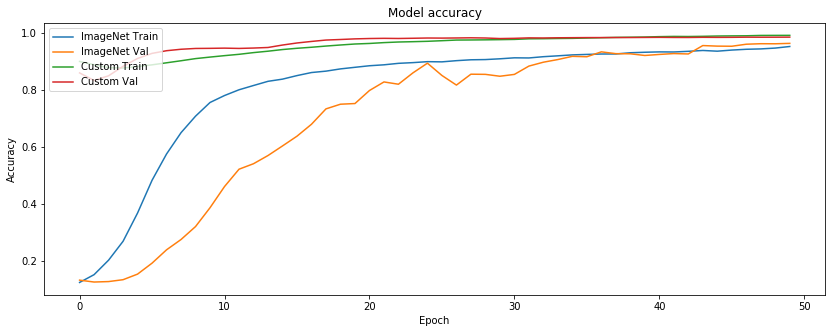

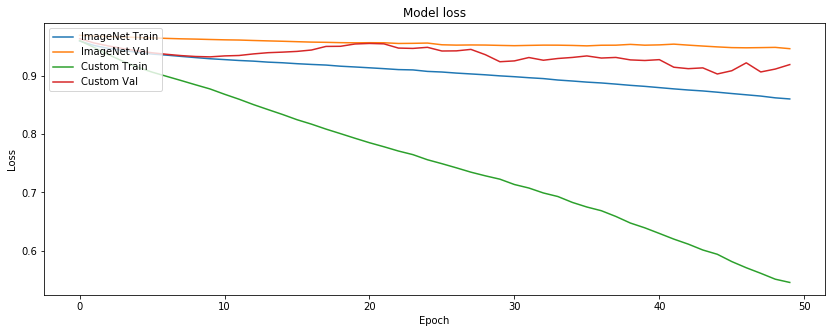

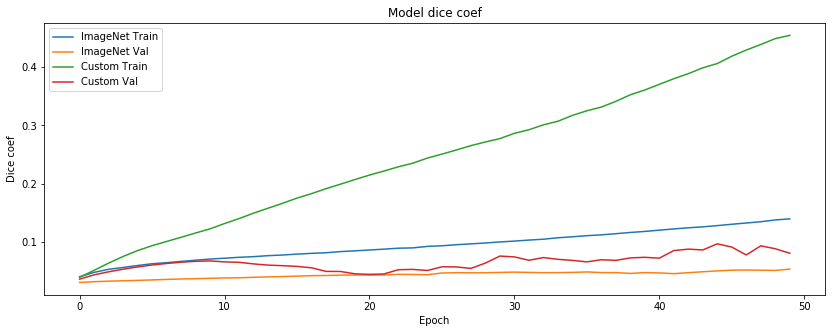

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))
plt.plot(imagenet_history.history['acc'])
plt.plot(imagenet_history.history['val_acc'])
plt.plot(custom_history['acc'])
plt.plot(custom_history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ImageNet Train', 'ImageNet Val', 'Custom Train', 'Custom Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(14,5))
plt.plot(imagenet_history.history['loss'])
plt.plot(imagenet_history.history['val_loss'])
plt.plot(custom_history['loss'])
plt.plot(custom_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ImageNet Train', 'ImageNet Val', 'Custom Train', 'Custom Val'], loc='upper left')
plt.show()

# Plot training & validation dice values
plt.figure(figsize=(14,5))
plt.plot(imagenet_history.history['dice_coef'])
plt.plot(imagenet_history.history['val_dice_coef'])
plt.plot(custom_history['dice_coef'])
plt.plot(custom_history['val_dice_coef'])
plt.title('Model dice coef')
plt.ylabel('Dice coef')
plt.xlabel('Epoch')
plt.legend(['ImageNet Train', 'ImageNet Val', 'Custom Train', 'Custom Val'], loc='upper left')
plt.show()

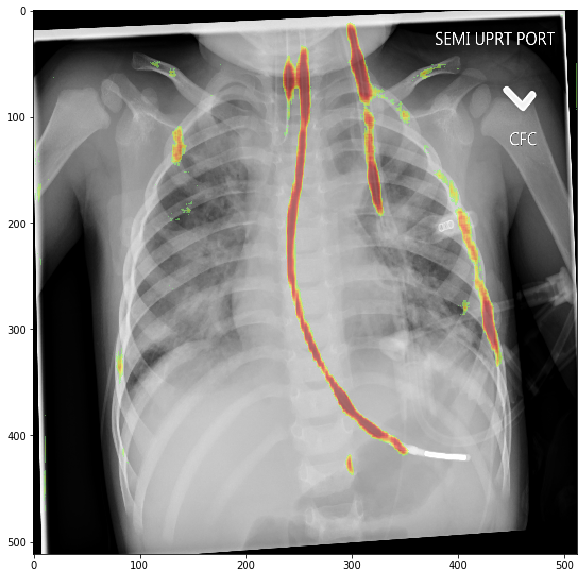

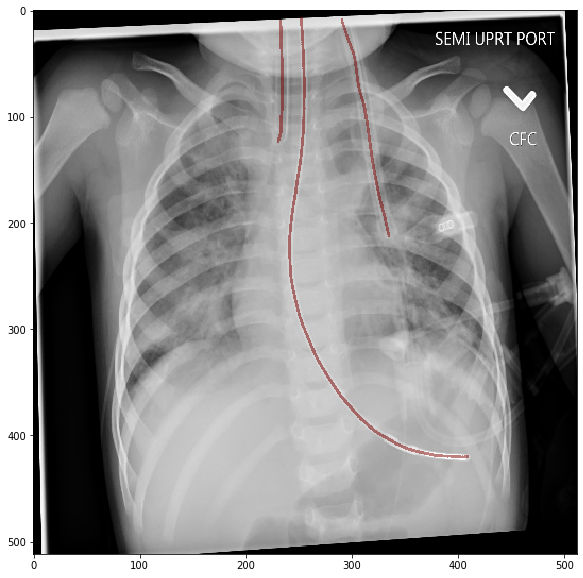

In [25]:
test_id = 1
predicted_mask = model.predict(np.expand_dims(X_test[test_id], axis=0))
plot_mask(X_test[test_id], predicted_mask)
plot_mask(X_test[test_id], Y_test[test_id])